# Table of Contents
| Section                      | Subsections                |
|-------------------------------|----------------------------|
|[Data Sources](#data-sources)|[Datasets](#datasets)|
|[Data Cleaning](#data-cleaning)| [Shapefiles](#shapefiles), [Rasters](#rasters)|
|[Data Exporting](#data-exporting)|--|

## Data Sources

All datasets were downloaded from the Government of Canada. Although attempts were made to use APIs, the lack of clear documentation and time constraints posed significant limitations.
Further links and citations can be found in Bibliography.txt

### Datasets
File Name | Layer Name | Details | Source |
| --- | --- | --- | --- | 
admin_boundaries |bc_polygon |shapefile - polygons| [Goverment of Canada](https://www.sciencebase.gov/catalog/item/5ab555c6e4b081f61ab78093) | 
BC_bedrock_ll83 | bc_rocks | shapefile - polygons | [British Columbia Geological Survey](https://www2.gov.bc.ca/gov/content/industry/mineral-exploration-mining/british-columbia-geological-survey/geology/bcdigitalgeology) |
new_age.csv | geochronolyBC | data from 1960 to 2020 | [as above](https://www2.gov.bc.ca/gov/content/industry/mineral-exploration-mining/british-columbia-geological-survey/publications/geofiles#GF2020-10) | 
BC_faults_ll83 | faults | shapefile - polylines | [as above - GeoPackage](https://www2.gov.bc.ca/gov/content/industry/mineral-exploration-mining/british-columbia-geological-survey/geology/bcdigitalgeology) 
MineralOccurrenceDataBC.csv | cmBC | shapefile - points  | [MINFILE BC](https://open.canada.ca/data/en/dataset/22b2db8a-dc12-47f2-9737-99d3da921751/resource/47e4cbb0-e19c-47c5-9c74-b4f68448b0d4)| 
--- |critical_minerals | shapefile - points | [Goverment of Canada](https://open.canada.ca/data/en/dataset/22b2db8a-dc12-47f2-9737-99d3da921751/resource/47e4cbb0-e19c-47c5-9c74-b4f68448b0d4) |
--- | grid_no_bc | multipolygone grid with 1Km square polygons for BC |  Author's own work| 
GRAV || Isostatic residual Bouguer anomaly -- 1000m res | [Goverment of Canada WMS ](http://wms.agg.nrcan.gc.ca/wms2/wms2.aspx?service=wms&version=1.3.0&request=GetCapabilities) 
GRAV_1VD || 1st vertical derivative 1000m res | as above
GRAV_A || Gravity Anomalies -- 1000m res  | as above
GRAV_HG | | Horizontal Gradient -- 1000m res | as above
MAG_1VD | | 1st vertical derivative of the Magnetic Field -- 200m res |as above
MAG_RMF | | Residual Magnetic Field -- 200m res | as above
RAD_* | | eK, eU, eTh -- 250m res| as above
RAD_* | | eTh/K, eU/eTh, eU/eTh -- 250m res | as above

## Data Cleaning

In this initial section of the notebook, the focus is on the essential data cleaning and transformation processes needed to establish a robust dataset for the mineral exploration dashboard, specifically targeting rare earth elements (REEs).

### CRS Considerations
The data cleaning process is divided into two parts in terms of CRS (Coordinate Reference System). For analysis purposes, all raster datasets and related data must be in a metric CRS. Thus, the EPSG:3153 CRS has been used throughout the analysis. At the end of this notebook, there is a section where the CRS can be reverted to the format requested by the challenge, along with a conversion to GeoJSON for dashboard implementation.

### Iterative Approach and Regional Focus
- **Initial Cleaning Scope**: Initially, the data cleaning efforts were concentrated solely on the British Columbia province. The plan was to integrate additional provinces; however, this was not feasible due to time constraints and computacional limitations.

### Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Import functions and reload the module after making changes
from scripts import utilities
import importlib
importlib.reload(utilities)
from scripts.utilities import read_shapefile, check_transform_crs, to_geodataframe,process_and_reproject_rasters, interactive_plot_raster, convert_raster_to_float, resample_rasters_to_resolution, shapefiles_to_geojson


#General libraries
import pandas as pd
import geopandas as gpd
import os
import gc
import numpy as np
from shapely.geometry import Point

#Raster
#from osgeo import gdal, osr
import rasterio



#Plotting
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown

### Shapefiles

#### Admin boundaries
In the early stages, polygons were used to perform "clipping" on raster datasets, focusing initially on British Columbia. This approach is documented in the legacy notebook, where I explain the reasons for eventually discontinuing this method.
British Columbia was chosen due to its relevance for rare earth elements (REEs), particularly the Wicheeda deposit. Although the initial plan was to expand the analysis to include Ontario and Quebec, this was not fully implemented in the final model due to project constraints.

Please note that throughout this notebook, I will consistently use utility functions such as `read_shapefile` and `check_transform_crs` from the `utilities` module. This module serves as a central repository for commonly used functions, streamlining processes and ensuring consistency across the entire notebook.

In [2]:
path2 = r'datasets/shp/originals/admin_boundaries.shp'
admin = read_shapefile(path2)
admin=check_transform_crs(admin,'EPSG:3153')


Shapefile loaded with 13 records
Columns: 7
Geometry type: ['MultiPolygon' 'Polygon']
Transforming from EPSG:4269 to EPSG:3153.


<Axes: >

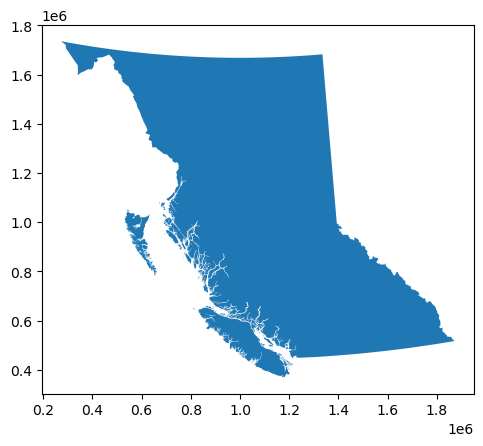

In [3]:
# target_province=admin[admin['PRENAME'].isin(['British Columbia','Nunavut','Ontario','Quebec','Yukon'])]
target_province=admin[admin['PRENAME'].isin(['British Columbia'])]#,'Ontario','Quebec'])]
target_province.to_file(r'datasets\shp\bc_polygon.shp')
target_province.plot()

#### Geology (_Polygon_), Geochronology (_Point_), Faults (_PolyLine_).
The datasets used in this section are specifically tailored for British Columbia. In order for the datasets t be ready for immediate use in our explorations, we need to ensure only relevant information is preserved.


Note: While geochemical data was collected for British Columbia, it was ultimately not used in the final analysis. The dataset only included `sediment samples` (stream, lake, moss), which were not suitable for the purposes of this study, particularly for analyzing rare earth elements (REEs), given the specific requirements for REE exploration.

In [4]:
bc= read_shapefile('datasets\shp\originals\BC_bedrock_ll83.shp')
bc=check_transform_crs(bc, 'EPSG:3153')
bc.drop(columns=['upid','gid','area_m2','period','era','strat_age','strat_name','gp_suite','fm_lithodm', 'mem_phase','rk_char', 'unit_desc','terrane', 'basin', 'basin_age', 'project', 'src_url', 'src_ref_s','map_comp', 'edit_date', 'pub_org'], inplace=True)
bc.head(1)

Shapefile loaded with 35424 records
Columns: 28
Geometry type: ['Polygon']
Transforming from EPSG:4269 to EPSG:3153.


,strat_unit,rock_class,rock_type,age_max,age_min,belt,geometry
0,DPBC,sedimentary rocks,"mudstone, siltstone, shale fine clastic sedime...",Upper Devonian,Permian,Omineca,"POLYGON ((1036229.310 1265500.000, 1036445.940..."


In [5]:
## for simplification we will use just de general lithology unit "rock_class"
bc_rocks=bc.dissolve(by='rock_class')
bc_rocks.reset_index(inplace=True)
bc_rocks.to_file(r'datasets\shp\bc_rocks.shp')
print(f'The original geodatagrame has {bc.shape[0]} rows, the simplied geodataframe has {bc_rocks.shape[0]}\n....')

# Force garbage collection and free up memory
del bc
gc.collect()
print(f'\n......\nmemory freed')

The original geodatagrame has 35424 rows, the simplied geodataframe has 11
....

......
memory freed


In [6]:
#Geocronology
new=to_geodataframe(r'datasets\new_age.csv','WGS84-lat','WGS84-long')
# NOTE: The "Sample age" field is not numeric. Six values are ranges such as "170-180".
# It might be useful to either convert these values into a numeric format or exclude them in later steps.

Error reading the file with utf-8. Trying with 'latin1' encoding...
GeoDataFrame created with 532 records
Geometry type: ['Point']
CRS=EPSG:4269


In [7]:
new.to_file(r'datasets\shp\geochronolyBC.shp')

In [8]:
## Faults, simplified geometry for regional scale 

faults = gpd.read_file(r'datasets\shp\originals\BC_faults_ll83.shp')
faults=check_transform_crs(faults,'EPSG:4326')


length_threshold = 5000  #Regional scale faults
filtered_faults = faults[faults['length_m'] > length_threshold]

faults_grouped= filtered_faults.groupby(['fault_name', 'fault_type'])

simplified_geoms = []
for (name, ftype), group in faults_grouped:
    # Merge geometries for the group using unary_union
    merged_geom = group.unary_union
    
    # Simplify the merged geometry
    simplified_geom = merged_geom.simplify(tolerance=0.01, preserve_topology=True)
    
    # Append the simplified geometry and its attributes to the list
    simplified_geoms.append({
        'fault_name': name,
        'fault_type': ftype,
        'geometry': simplified_geom
    })

simplified_gdf_faults = gpd.GeoDataFrame(simplified_geoms)

# Save the simplified GeoDataFrame to a new GeoJSON file as I'm not using it in the analysis
simplified_gdf_faults.to_file(r'datasets\geojson\BC_faults.geojson', driver='GeoJSON')

Transforming from EPSG:4269 to EPSG:4326.


#### Critical Minerales occurrences across Canada
From British Columbia geology survey - MINFILE

In [9]:
### This csv file has a special condition to open it correctly, so the cleaning it will be performed here
df = pd.read_csv('datasets/MineralOccurrenceDataBC.csv', delimiter=r'[,\t]+', engine='python') 
df=df.applymap(lambda x: x.strip() if isinstance(x,str) else x)
df.head(1)

,MINFILNO,NAME1,NAME2,STATUS_C,STATUS_D,LATITUDE,LAT_DEG,LAT_MIN,LAT_SEC,LAT_HEMI,...,NTSMAP_C1,NTSMAP_C2,PRODUCTN,RESERVES,REGION_C1,REGION_D1,REGION_C2,REGION_D2,URL,Unnamed: 56
0,082FSE068,OPTION,SKY,PROS,Prospect,49.151666,49,9,6,N,...,082F01E,,N,N,BC,British Columbia,,,http://minfile.gov.bc.ca/Summary.aspx?minfilno...,NaN


The information provided is extensive and, at this stage, unnecessary for further analysis. Therefore, I retain only the columns that are relevant. A more effective approach would be to perform a join with geological data to enrich the dataset.
The CRS transformation was performed with the intention of creating features for the model, such as distance to faults, distance to deposits, and other spatial relationships essential for the analysis. However, this was ultimately not achieved.



In [11]:
columns= [4,5,10,19,20,21,37]
CM_2=df.iloc[:, columns].copy()

#Convert DF to GeoDF
geometry = [Point(xy) for xy in zip(df['LONGITUDE'], df['LATITUDE'])]
gdf = gpd.GeoDataFrame(CM_2, geometry= geometry)
gdf.set_crs(epsg=4269, inplace=True)
gdf=check_transform_crs(gdf, 'EPSG:3153') ### This transformation was made for feature engineering the model
print(f"GeoDataFrame created with {len(gdf)} records\nGeometry type: {gdf.geom_type.unique()}\nCRS={gdf.crs}")

# #Intersect CM points with BC polygons
bc_cm=gpd.sjoin(gdf,bc_rocks, how='inner', op='within')
bc_cm.head(2)

Transforming from EPSG:4269 to EPSG:3153.
GeoDataFrame created with 65 records
Geometry type: ['Point']
CRS=EPSG:3153


,STATUS_D,LATITUDE,LONGITUDE,COMMOD_C1,COMMOD_C2,COMMOD_C3,DEPTYPE_D1,geometry,index_right,rock_class,strat_unit,rock_type,age_max,age_min,belt
0,Prospect,49.151666,-116.21444,CU,AU,WO,Polymetallic veins Ag-Pb-Zn+/-Au,POINT (1712345.013 508793.306),5,sedimentary rocks,DPBC,"mudstone, siltstone, shale fine clastic sedime...",Upper Devonian,Permian,Omineca
1,Showing,49.459722,-117.59277,NB,TA,UR,Five-element veins Ni-Co-As-Ag+/-(Bi-U),POINT (1608464.203 529884.983),0,intrusive rocks,KTgr,"granite, alkali feldspar granite intrusive rocks",Cretaceous,Tertiary,Omineca


In [12]:
bc_cm.drop(columns=['LATITUDE', 'LONGITUDE','index_right'], inplace= True)
bc_cm.to_file(r'datasets\shp\cmBC.shp')

From Canada's Goverment
(Critical Minerals Canada)

In [14]:
CM=gpd.read_file(r'datasets\shp\originals\critical_minerals.shp')
CM=check_transform_crs(CM, 'EPSG:3153' )

Transforming from EPSG:3978 to EPSG:3153.


In [15]:
CM.to_file(r'datasets\geojson\critical_minerals.geojson', driver='GeoJSON')

### Interactivce map

In [16]:
CM.columns

Index(['OBJECTID', 'OperationG', 'Operatio_1', 'PropertyNa', 'Property_1',
       'OperatorOw', 'Operator_1', 'ProvincesE', 'ProvincesF', 'Commoditie',
       'Commodit_1', 'Developmen', 'Developm_1', 'ActivitySt', 'Activity_1',
       'Latitude', 'Longitude', 'Website', 'ID', 'EA_Status', 'geometry'],
      dtype='object')

In [ ]:
##Interactive map targeting CM column 
filter_values = bc_cm['Commoditie'].unique() #Here we can change any specific column we want to interact with. For now is just set to work with bc_cm gdf.
# column2_values = bc_cm['Developmen'].unique()

@interact(Filter=filter_values)
def show_map(Filter):

    fig, ax = plt.subplots(figsize=(10,10))
    
    #Rock type
    bc_rocks.plot(ax=ax, column='rock_class', legend=True, cmap='viridis')
    
    #Geocronology
    new.plot(ax=ax, color ='black', marker ='o', markersize=7, alpha=0.6)
    # Adding labels for geochronology points
    # for x, y, label in zip(new.geometry.x, new.geometry.y, new['Sample Age']):
    #     ax.text(x, y, label, fontsize=8, ha='right', color='black')

    #Filtering by value for interactive map
    data_filtered = bc_cm[bc_cm['Commoditie'] == Filter]
    data_filtered.plot(ax=ax, color='red', marker='o', markersize=10)

    ## Adding prospect points of interests
    poi = bc_cm[bc_cm['Commoditie']=='Rare earth elements']
    # x = poi.geometry.x.iloc[0]
    # y = poi.geometry.y.iloc[0]
    for x,y label in zip(poi.geometry.x,poi.geometry.y, poi['COMMOD_C2']):
        ax.text(x,y,label,fontsize=7,ha='left',color='black')


    ax.scatter(x,y, color='white', marker='*', s=70)
    ax.text(x,y,'Wicheeda', fontsize=7, ha='left', color ='white')
   

    plt.title('BC simplyfied map by rock class')
    plt.show()

The CM dataset has 10 ocurrecens of critical minerals across Canada. It's the purpose to integrate those targets in the final model.

In [19]:
CM[CM['Commoditie']=='Rare earth elements'].iloc[:,7:18]

,ProvincesE,ProvincesF,Commoditie,Commodit_1,Developmen,Developm_1,ActivitySt,Activity_1,Latitude,Longitude,Website
144,Quebec,Québec,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,On hold / suspended,En attente / suspendu,46.817470,-78.474500,http://www.qpmcorp.ca
163,Quebec,Québec,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,Active,En activité,56.945830,-68.404170,https://commerceresources.com
199,Northwest Territories,Territoires du Nord-Ouest,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,Active,En activité,62.118060,-112.599720,https://vitalmetals.com.au
214,Newfoundland and Labrador,Terre-Neuve-et-Labrador,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,On hold / suspended,En attente / suspendu,52.398330,-55.824170,Not available/Pas disponible
223,Saskatchewan,Saskatchewan,Rare earth elements,Éléments des terres rares,Advanced processing project,Projet de traitement avancé,Active,En activité,52.140033,-106.627370,https://www.src.sk.ca/campaigns/rare-earth-pro...
224,Ontario,Ontario,Rare earth elements,Éléments des terres rares,Demonstration plant,Usine de démonstration,Active,En activité,44.233334,-76.500000,https://ucore.com/rapidsx/
227,Quebec,Québec,Rare earth elements,Éléments des terres rares,Advanced unconventional project,Projet avancé non conventionnel,Active,En activité,45.525976,-73.340812,https://geomega.ca
230,Saskatchewan,Saskatchewan,Rare earth elements,Éléments des terres rares,Advanced processing project,Projet de traitement avancé,On hold / suspended,En attente / suspendu,52.176809,-106.656706,https://vitalmetals.com.au
232,Quebec,Québec,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,On hold / suspended,En attente / suspendu,48.542770,-71.154450,https://www.magrispm.com
263,British Columbia,Colombie-Britannique,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,Active,En activité,54.531410,-122.099120,https://defensemetals.com


### Rasters
### Raster Processing: 

- **Data Type**: I'll preprocess the original raster data by converting it from uint8 to float32. This conversion allows for the handling of NaN values, ensures greater precision for mathematical operations.

- **Reprojected & Cropped**: All rasters are reprojected to a fixed CRS (`EPSG:3153`) for better spatial resolution at British Columbia province. Due to the diverse geological characteristics of REE deposits, isolating relevant data for each type is essential. In BC, for example, the focus is on carbonatite-type deposits. The goal is to later incorporate other regions to explore potential generalizations across different deposit types.

- **Resampled**: The raster datasets vary in resolution from 100 meters to 1000 meters. The **1000-meter** resolution rasters, which are of geophysical interest and cover the entire British Columbia region, will be used as a baseline to resample higher-resolution rasters to this regional scale. This approach aims to enhance the identification of potential prospective zones

Data type to float32

In [33]:
raster_paths = [os.path.join(r'datasets\raster\originals', f) for f in os.listdir(r'datasets\raster\originals') if f.lower().endswith('.tif')]
output_path = r'datasets\raster\float'

for path in raster_paths:
    convert_raster_to_float(path, output_path)

Reproject and Crop 

In [ ]:
raster_paths = [os.path.join(r'datasets\raster\float', f) for f in os.listdir(r'datasets\raster\float') if f.lower().endswith('.tif')]
output_directory = r'datasets\raster\cropped_reprojected'
process_and_reproject_rasters(raster_paths, target_province, output_directory, 'EPSG:3153')

In [ ]:
#checking metadata
def print_metadata(file_path):
    with rasterio.open(file_path) as src:
        print("CRS:", src.crs)
        print("Resolution:", src.res)
        print("Bounds:", src.bounds)
        print("Tags:", src.tags())


for filename in os.listdir(r'datasets\raster\cropped_reprojected'):
    if filename.lower().endswith(".tif"):
        file_path = os.path.join(r'datasets\raster\cropped_reprojected', filename)
        print_metadata(file_path)

#### Resamplig -- standarizing resolution across all rasters


These are the final results of the raster preprocessing, and they are the ones used in the analysis. Due to file size considerations, only these files will remain in the corresponding folder.

In [ ]:
###Checking max - min resolution for resampling####

def find_lowest_resolution(raster_paths):
    """
    Finds the lowest resolution (i.e., the highest pixel size) among a list of raster files.
    
    Args:
    raster_paths (list of str): Paths to the raster files.
    
    Returns:
    float: The highest pixel width and height found among the rasters.
    """
    max_pixel_size = 0
    for path in raster_paths:
        with rasterio.open(path) as src:
            pixel_size = src.res[0]  # Assuming square pixels, x resolution
            if pixel_size > max_pixel_size:
                max_pixel_size = pixel_size
    return max_pixel_size


raster_paths = [os.path.join(r'datasets\raster\cropped_reprojected', f) for f in os.listdir(r'datasets\raster\cropped_reprojected') if f.lower().endswith('.tif')]
lowest= find_lowest_resolution (raster_paths)
lowest

In [ ]:
raster_paths = [os.path.join(r'datasets\raster\cropped_reprojected', f) for f in os.listdir(r'datasets\raster\cropped_reprojected') if f.lower().endswith('.tif') and f.lower().startswith('cropped_')]
output_directory = r'datasets\raster\resampled'

resample_rasters_to_resolution(raster_paths, output_directory, lowest)

In [ ]:
#Checking resampling
for filename in os.listdir(r'datasets\raster\resampled'):
    if filename.lower().endswith(".tif"):
        file_path = os.path.join(r'datasets\raster\resampled', filename)
        print_metadata(file_path)

###NICE!! We are finally fine to go! ##

## Plotting layers

By default, the first TIFF file found in the directory will be plotted, and additional rasters can be selected using the dropdown menu, which will append them to the end of the output.


In [ ]:
bc_cm[bc_cm['COMMOD_C1']=='RS']

Dropdown(options=('resampled_cropped_reprojected_AGG_Canada 2 km - GRAV - 1st Vertical Derivative_float.tif', …

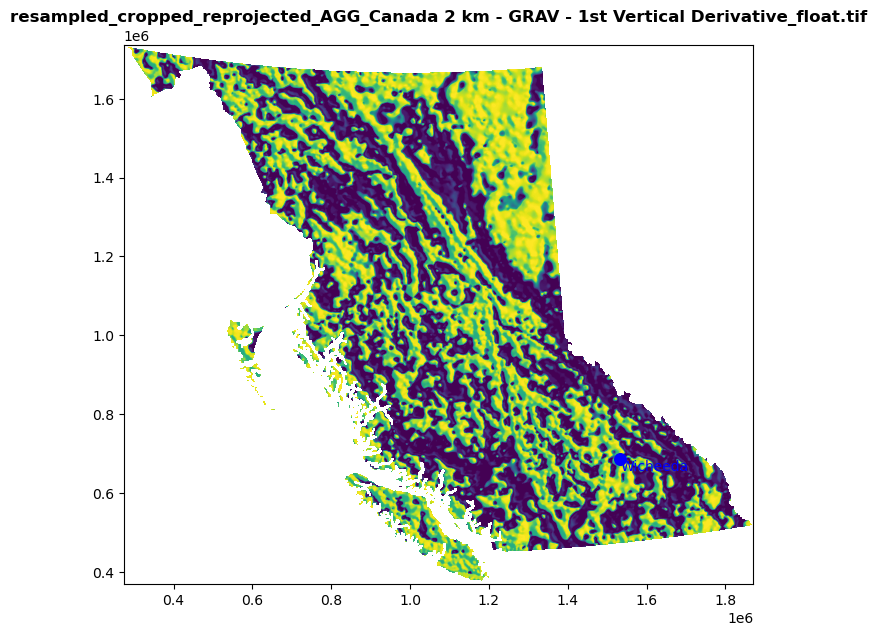

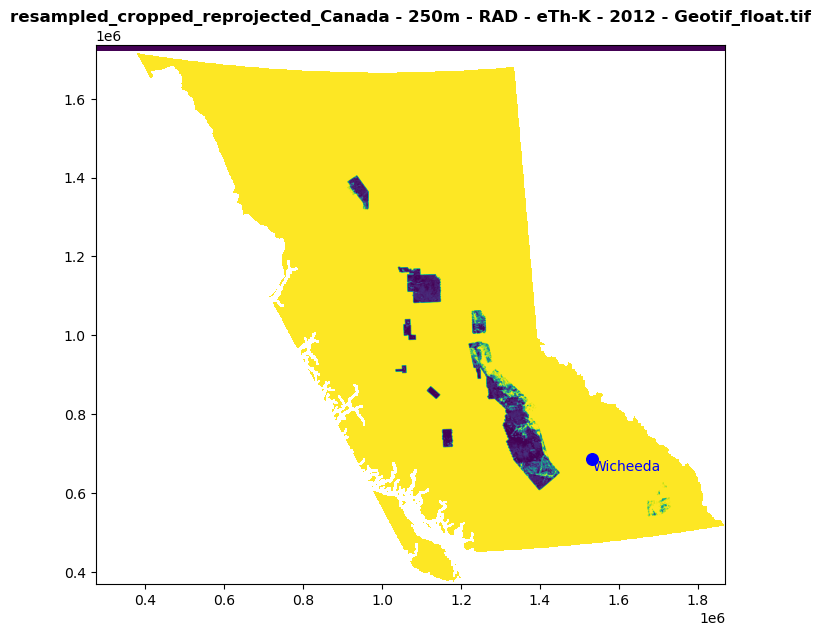

In [20]:
REE = bc_cm[bc_cm['COMMOD_C1']=='RS']
# Example usage of the function with a directory and the point of interest loaded as GeoDataFrame
interactive_plot_raster(r"datasets/raster/resampled", REE)

## Data Exporting

At the conclusion of the analysis (notebook 2), I utilized this process for visualization and exported the shapefiles as GeoJSON, ensuring conversion to the required CRS (EPSG:4326).

In [21]:
shapefiles= [r'datasets\shp\bc_rocks.shp',r'datasets\shp\cmBC.shp']
geojsons = [r'datasets\geojson\bc_rocks.geojson',r'datasets\geojson\cmBC.geojson']

shapefiles_to_geojson(shapefiles, geojsons)

Transforming from EPSG:3153 to EPSG:4326.
Shapefile datasets\shp\bc_rocks.shp convertido a GeoJSON en datasets\geojson\bc_rocks.geojson
Transforming from EPSG:3153 to EPSG:4326.
Shapefile datasets\shp\cmBC.shp convertido a GeoJSON en datasets\geojson\cmBC.geojson
